In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [18]:
energy = pd.read_csv('data/energy_clean.csv', index_col=0, parse_dates=True)
weather = pd.read_csv('data/weather_clean.csv', index_col=0, parse_dates=True)
df = pd.read_csv('data/df_clean.csv', index_col=0, parse_dates=True)

# max

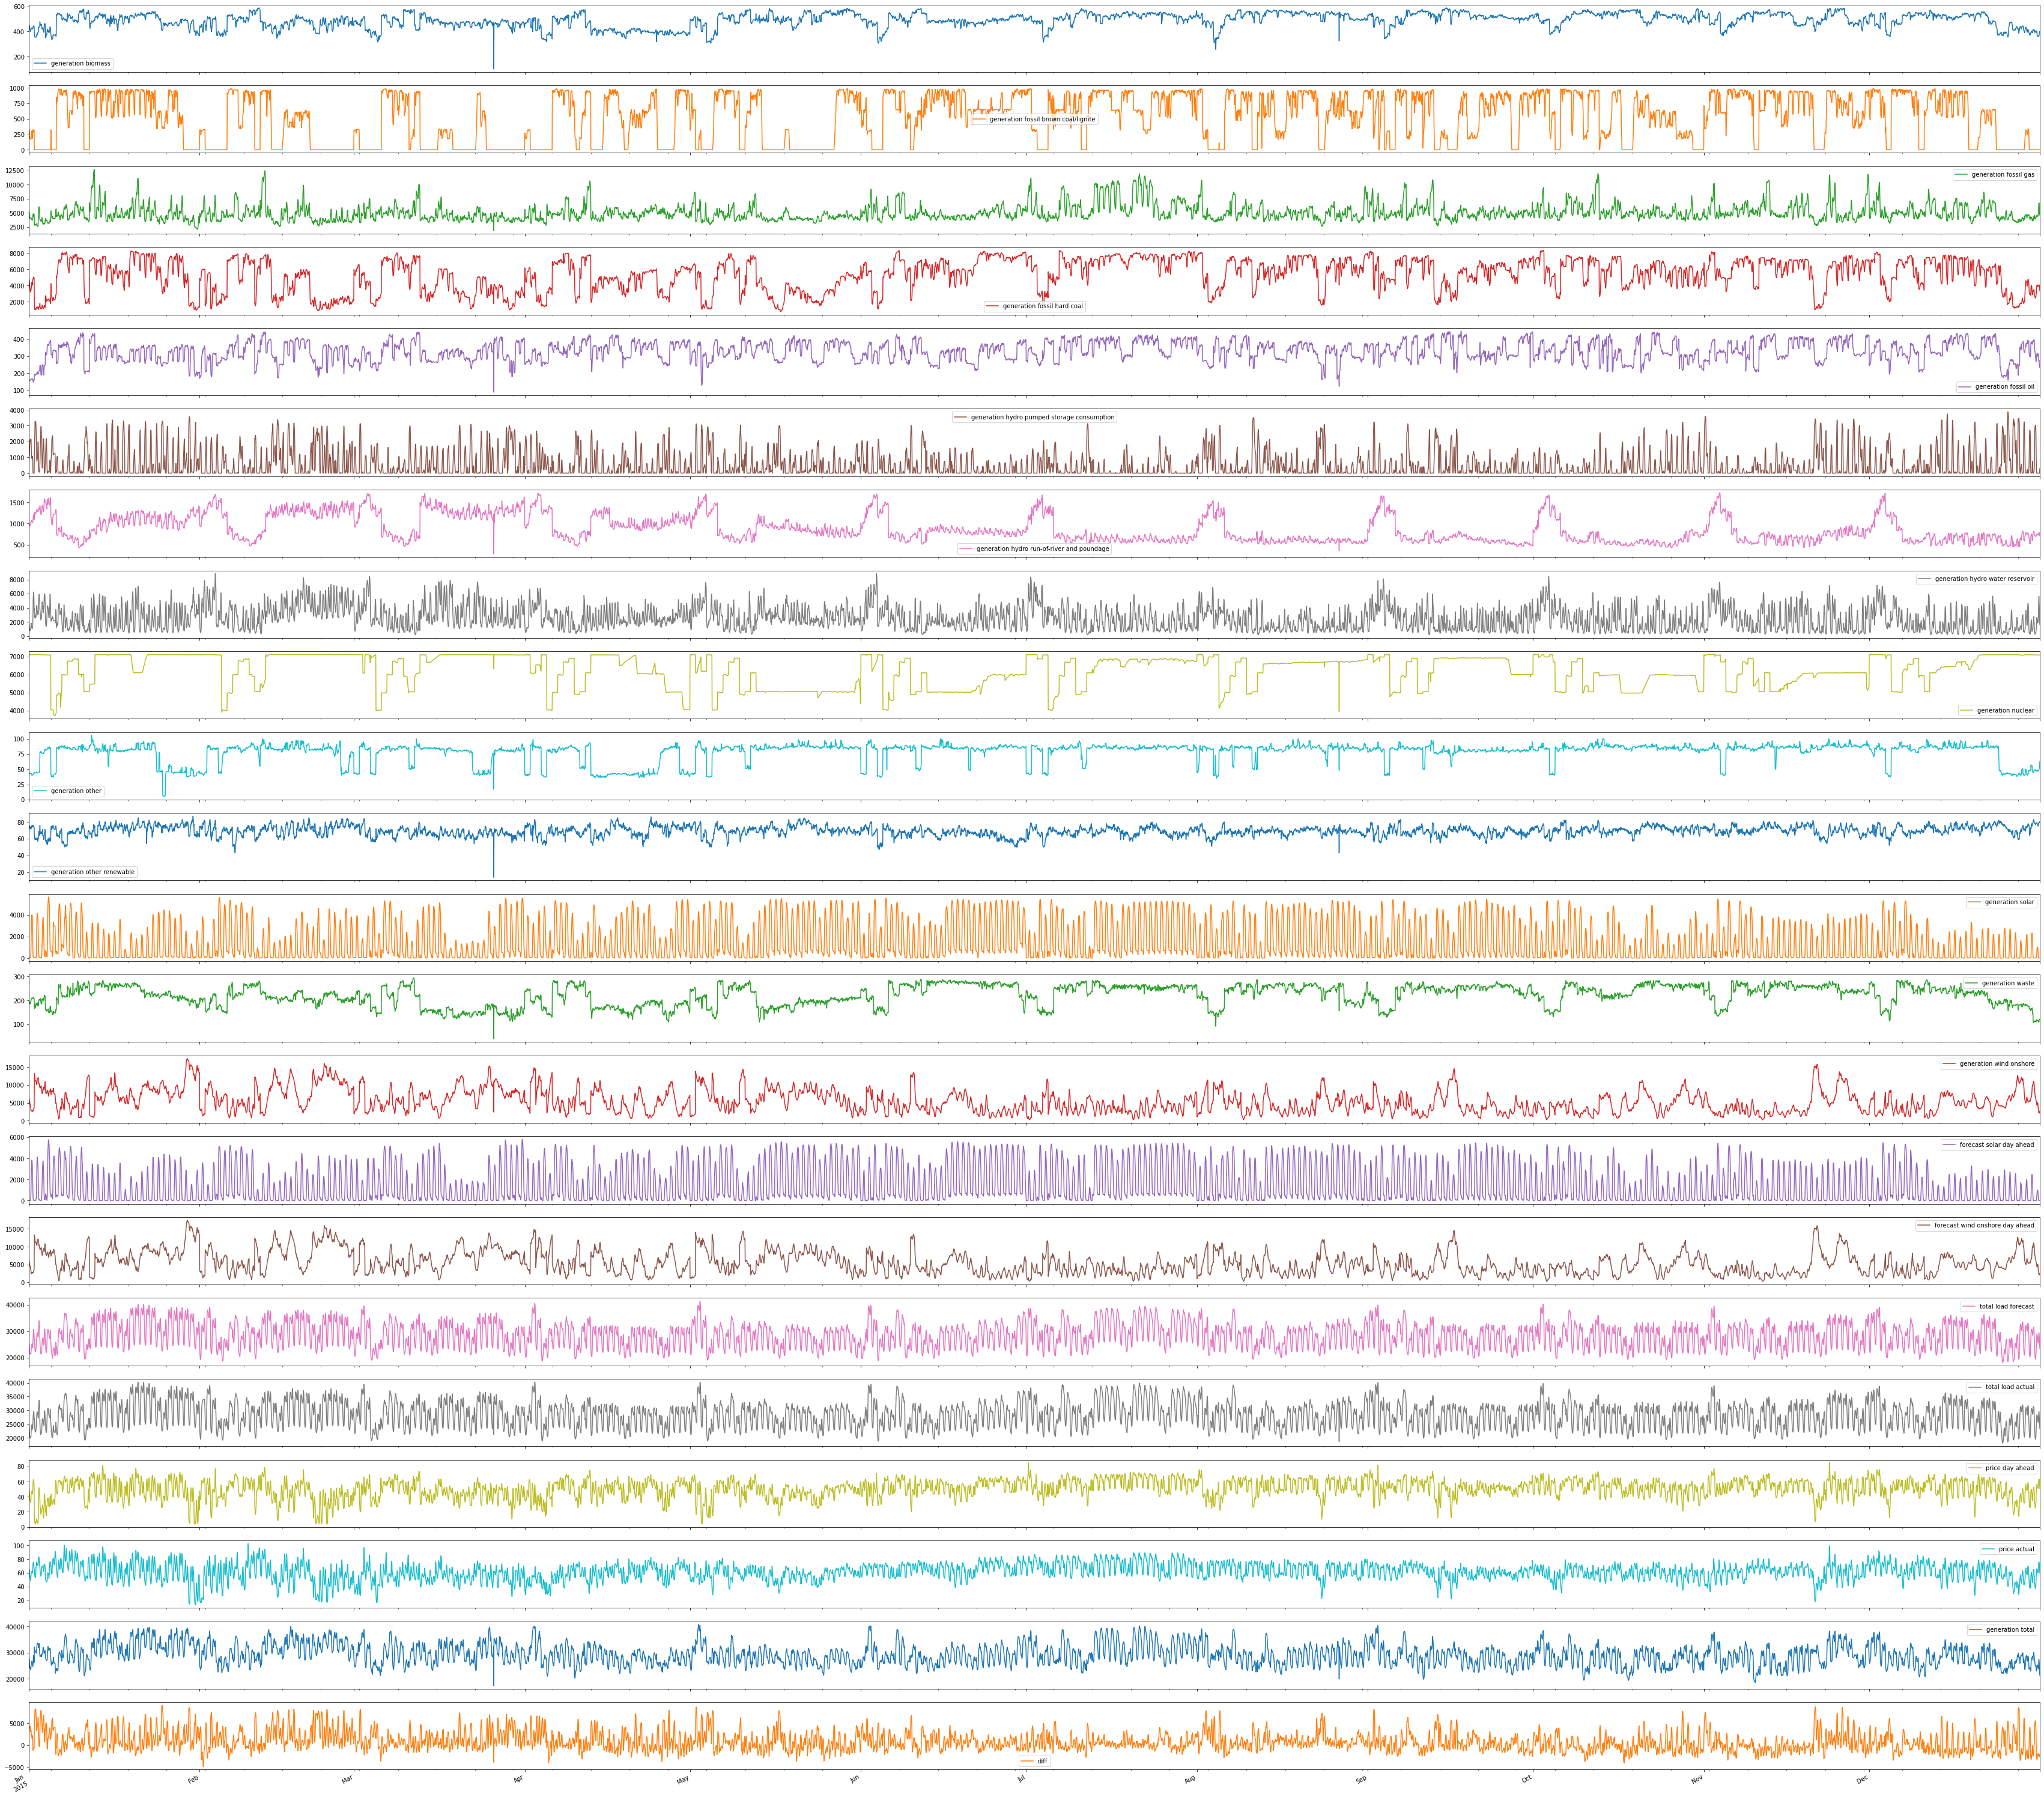

In [19]:
# Plot first year
yr_2015 = energy.loc['2015-01-01 00:00:00':'2015-12-31 23:00:00'].copy()
yr_2015.plot(subplots = True, figsize=(60,60));

## Overall Energy Generation by Year
___

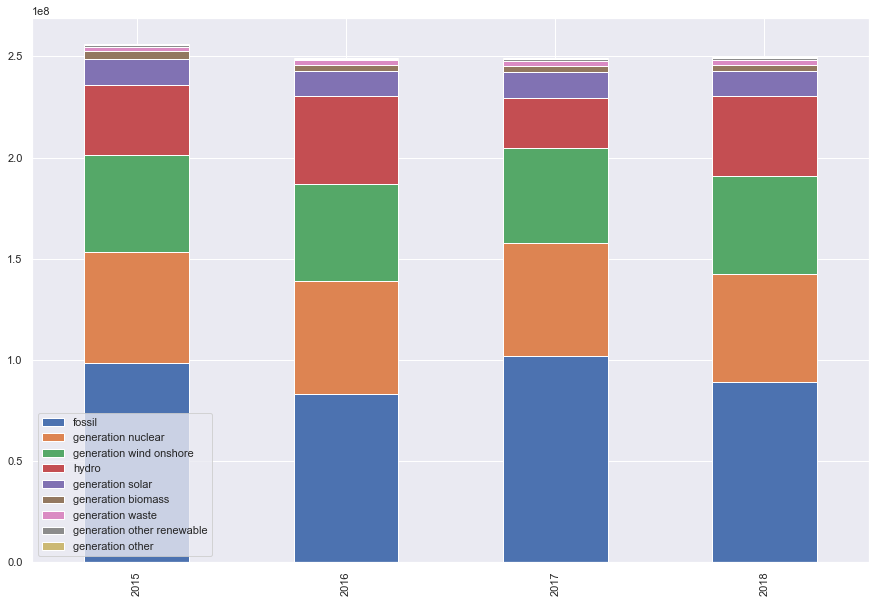

In [20]:
generation = energy.iloc[:, :14].copy()
fossil = ['generation fossil brown coal/lignite',
                                   'generation fossil gas',
                                   'generation fossil hard coal',
                                   'generation fossil oil',]
hydro = ['generation hydro pumped storage consumption',
                                  'generation hydro run-of-river and poundage',
                                  'generation hydro water reservoir']
generation['fossil'] = generation[fossil].sum(axis=1)
generation['hydro'] = generation[hydro].sum(axis=1)
generation.drop(columns = fossil+hydro, inplace=True)
generation_by_year = generation.groupby(by=generation.index.year).sum()
order = generation_by_year.sum(axis=0).sort_values(ascending=False).index
sns.set_theme()
generation_by_year[order].plot(kind='bar', stacked=True, figsize=(15,10));


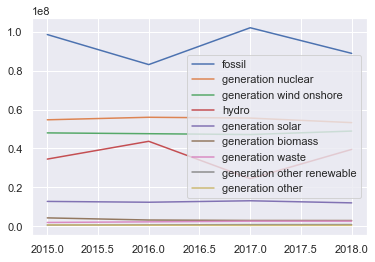

In [21]:
generation_by_year[order].plot();

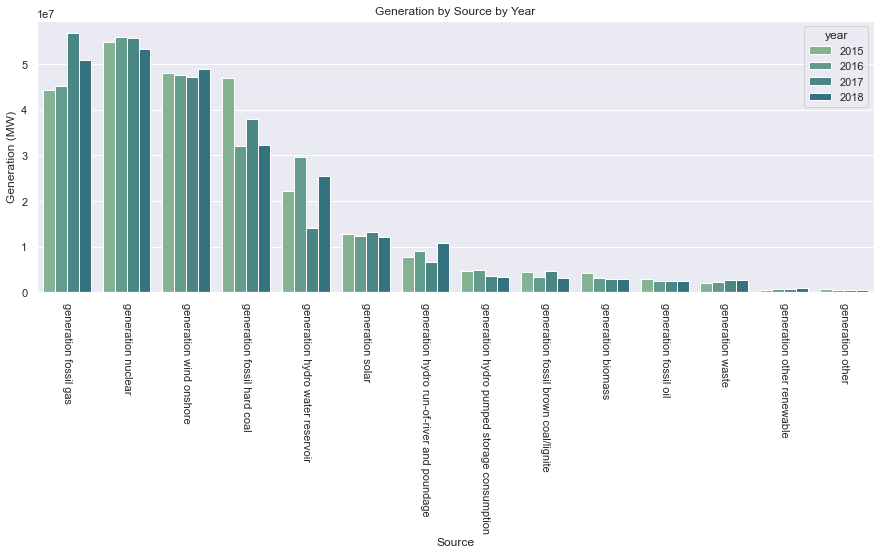

In [22]:
energy_by_year = energy.groupby(by=energy.index.year).sum().iloc[:,:14].reset_index().rename(columns={'index':'year'})
chart = energy_by_year.melt('year', var_name = 'Source', value_name = 'Generation (MW)')
chart.sort_values(by=['Generation (MW)', 'year'], ascending=False, inplace=True)

colors = sns.color_palette("crest");
plt.figure(figsize=(15,5));
sns.barplot(x='Source',
            y='Generation (MW)',
            hue='year',
            data=chart,
            palette=colors);
plt.xticks(rotation = -90);
plt.title('Generation by Source by Year');


## Total Energy Generation
___

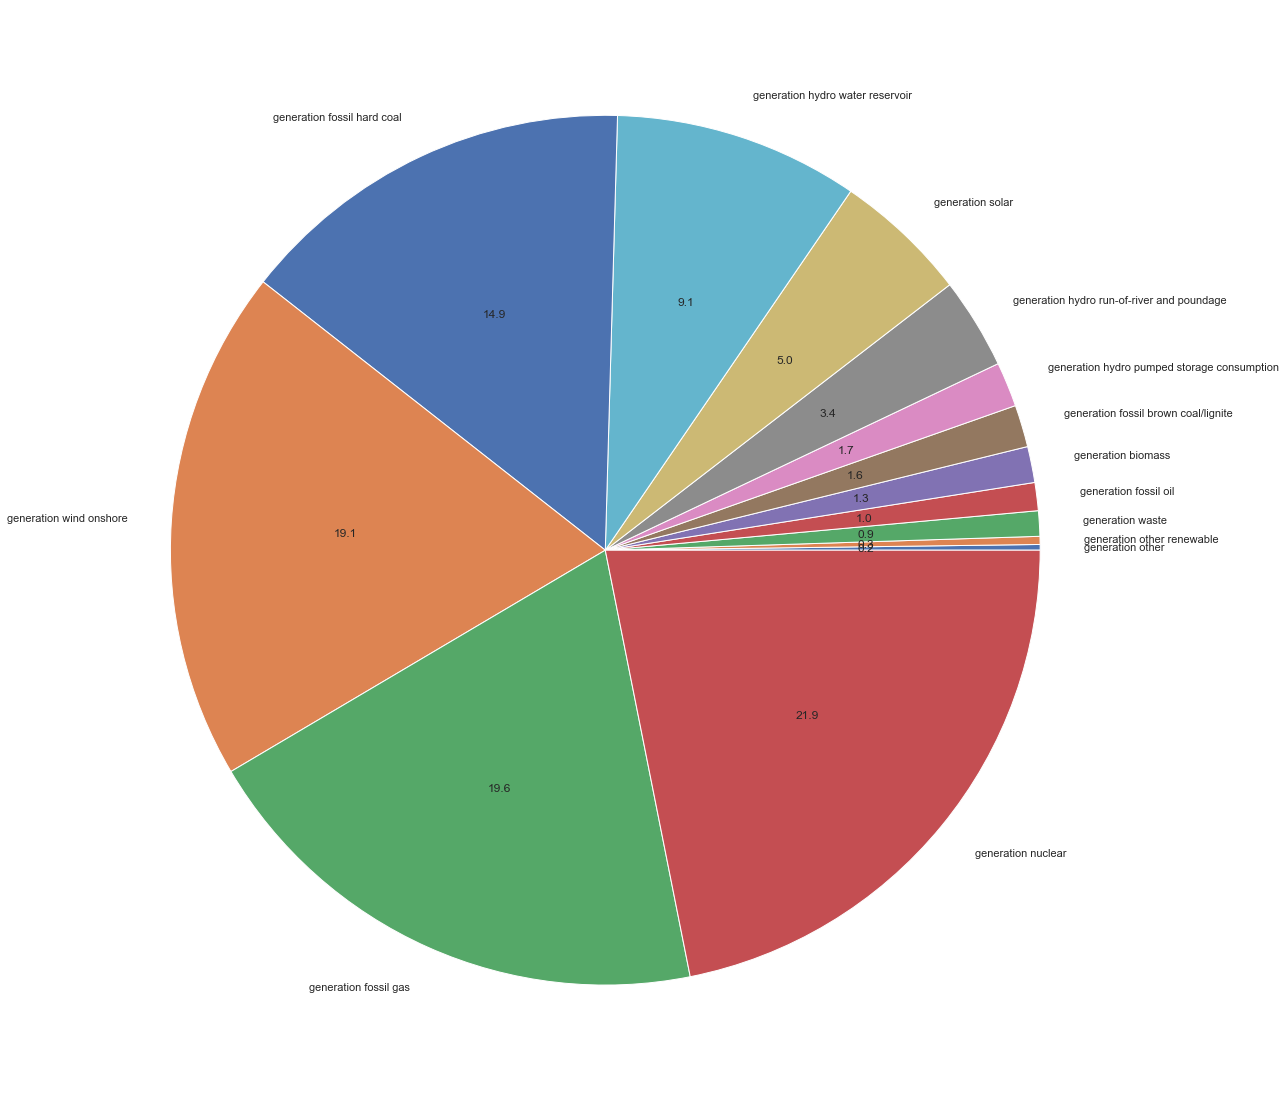

In [23]:
energy_sorted=energy.sum()[:14].sort_values()
plt.figure(figsize=(20,20))
plt.pie(energy_sorted, labels=energy_sorted.index, autopct='%.1f');

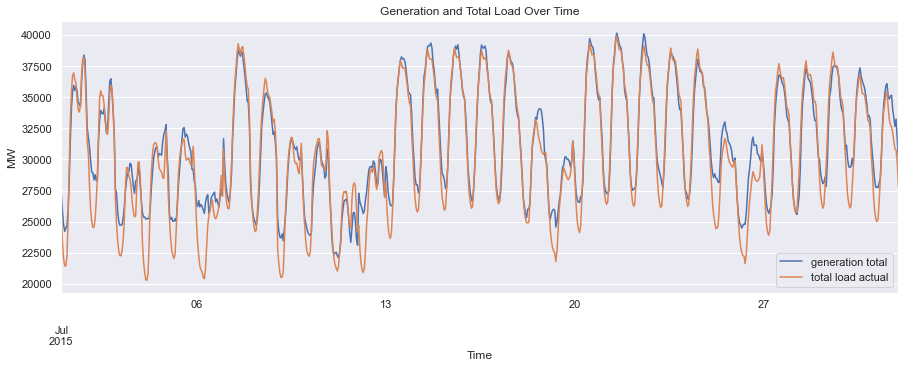

In [24]:
energy.loc['2015-07','generation total'].plot(figsize=(15,5), legend=True);
energy.loc['2015-07','total load actual'].plot(figsize=(15,5), legend=True);
plt.title('Generation and Total Load Over Time');
plt.xlabel('Time');
plt.ylabel('MW');

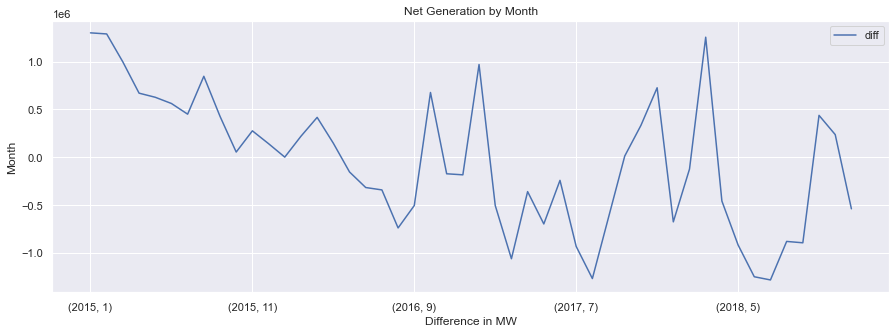

In [25]:
energy.groupby(by=[energy.index.year, energy.index.month]).sum()['diff'].plot(figsize=(15,5), legend=True);
plt.title('Net Generation by Month');
plt.ylabel('Month');
plt.xlabel('Difference in MW');

## Energy Correlations
___

In [26]:
energy.corr()

generation biomass  \
generation biomass                                     1.000000   
generation fossil brown coal/lignite                   0.229757   
generation fossil gas                                 -0.020829   
generation fossil hard coal                            0.433264   
generation fossil oil                                  0.458333   
generation hydro pumped storage consumption           -0.045156   
generation hydro run-of-river and poundage            -0.285921   
generation hydro water reservoir                      -0.033862   
generation nuclear                                    -0.023993   
generation other                                       0.657971   
generation other renewable                            -0.564251   
generation solar                                      -0.005042   
generation waste                                      -0.348861   
generation wind onshore                               -0.069374   
forecast solar day ahead                              -0.008736   
forecast wind onshore day ahead                       -0.072220   
total load forecast                                    0.086276   
total load actual                                      0.084187   
price day ahead                                        0.109721   
price actual                                           0.143076   
generation total                                       0.124039   
diff                                                   0.051899   

                                             generation fossil brown coal/lignite  \
generation biomass                                                       0.229757   
generation fossil brown coal/lignite                                     1.000000   
generation fossil gas                                                    0.500410   
generation fossil hard coal                                              0.768880   
generation fossil oil                                                    0.314873   
generation hydro pumped storage consumption                             -0.324311   
generation hydro run-of-river and poundage                              -0.525307   
generation hydro water reservoir                                        -0.229051   
generation nuclear                                                      -0.008470   
generation other                                                         0.097367   
generation other renewable                                               0.104149   
generation solar                                                         0.040130   
generation waste                                                         0.282718   
generation wind onshore                                                 -0.434350   
forecast solar day ahead                                                 0.041982   
forecast wind onshore day ahead                                         -0.436035   
total load forecast                                                      0.279580   
total load actual                                                        0.281219   
price day ahead                                                          0.568483   
price actual                                                             0.364287   
generation total                                                         0.189425   
diff                                                                    -0.191228   

                                             generation fossil gas  \
generation biomass                                       -0.020829   
generation fossil brown coal/lignite                      0.500410   
generation fossil gas                                     1.000000   
generation fossil hard coal                               0.542379   
generation fossil oil                                     0.311016   
generation hydro pumped storage consumption              -0.420777   
generation hydro run-of-river and poundage               

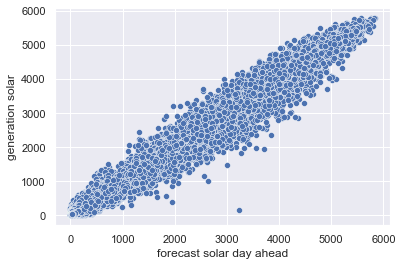

In [28]:
sns.scatterplot(data=energy, y='generation solar', x='forecast solar day ahead');

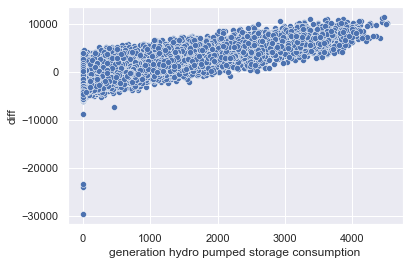

In [29]:
sns.scatterplot(x='generation hydro pumped storage consumption',y='diff', data=energy);

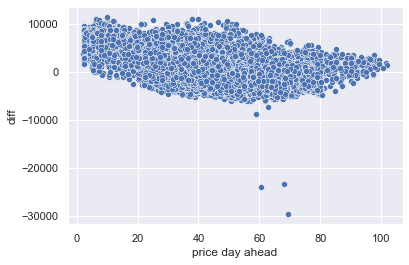

In [30]:
sns.scatterplot(x='price day ahead', y='diff', data=energy, legend=True);

## Difference in Load Forecast and Actual Load
___

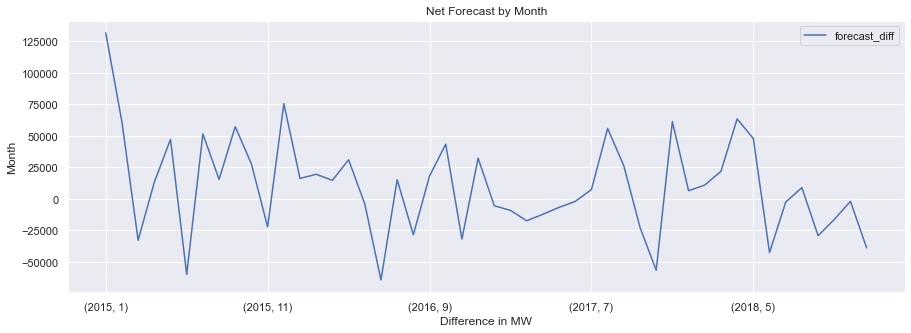

In [31]:
energy['forecast_diff'] = energy['total load forecast'] - energy['total load actual']
energy.groupby(by=[energy.index.year, energy.index.month]).sum()['forecast_diff'].plot(figsize=(15,5), legend=True);
plt.title('Net Forecast by Month');
plt.ylabel('Month');
plt.xlabel('Difference in MW');

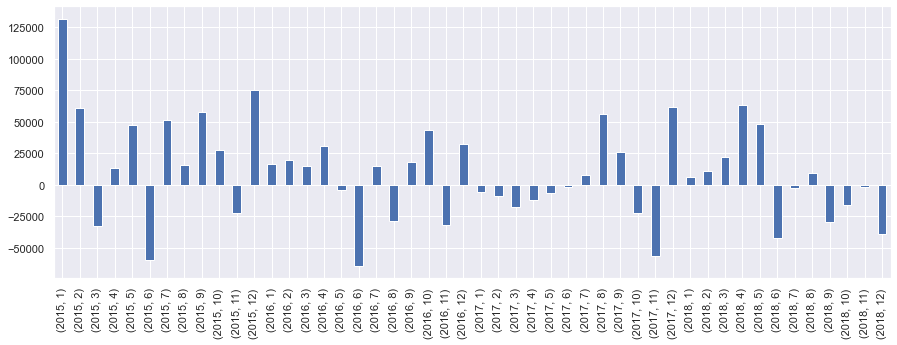

In [32]:
energy.groupby(by=[energy.index.year, energy.index.month]).sum()['forecast_diff'].plot(kind='bar', figsize=(15,5));

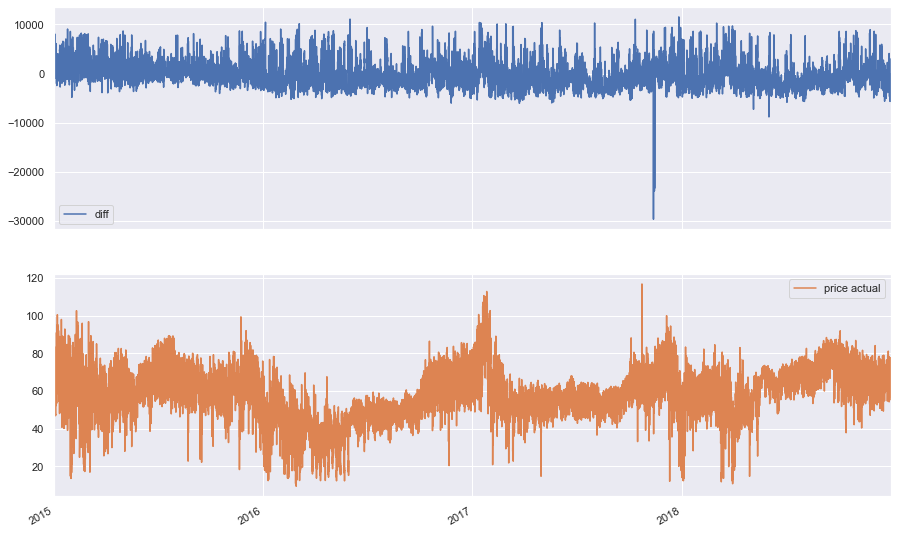

In [76]:
energy[['diff', 'price actual']].plot(subplots=True,figsize=(15,10));

In [93]:
energy.loc[abs(energy['diff'])>energy['total load actual']*.6]

generation biomass  generation fossil brown coal/lignite  \
2017-11-12 21:00:00               358.0                                 634.0   
2017-11-14 12:00:00               371.0                                 943.0   
2017-11-14 19:00:00               379.0                                 979.5   

                     generation fossil gas  generation fossil hard coal  \
2017-11-12 21:00:00                 6899.0                       5910.5   
2017-11-14 12:00:00                10064.0                       6694.0   
2017-11-14 19:00:00                12336.0                       7051.0   

                     generation fossil oil  \
2017-11-12 21:00:00                  352.5   
2017-11-14 12:00:00                  324.5   
2017-11-14 19:00:00                  339.5   

                     generation hydro pumped storage consumption  \
2017-11-12 21:00:00                                          0.0   
2017-11-14 12:00:00                                          0.0   
2017-11-14 19:00:00                                          0.0   

                     generation hydro run-of-river and poundage  \
2017-11-12 21:00:00                                      1214.0   
2017-11-14 12:00:00                                       505.0   
2017-11-14 19:00:00                                       577.5   

                     generation hydro water reservoir  generation nuclear  \
2017-11-12 21:00:00                            1424.5              7087.5   
2017-11-14 12:00:00                             397.0              5047.5   
2017-11-14 19:00:00                            2505.0              5048.5   

                     generation other  ...  generation wind onshore  \
2017-11-12 21:00:00              49.5  ...                   8434.0   
2017-11-14 12:00:00              11.0  ...                   7593.5   
2017-11-14 19:00:00              11.5  ...                   5744.0   

                     forecast solar day ahead  \
2017-11-12 21:00:00                      36.0   
2017-11-14 12:00:00                    4325.0   
2017-11-14 19:00:00                     128.0   

                     forecast wind onshore day ahead  total load forecast  \
2017-11-12 21:00:00                           8536.0              36671.0   
2017-11-14 12:00:00                           7561.0              33805.0   
2017-11-14 19:00:00                           5679.0              35592.0   

                     total load actual  price day ahead  price actual  \
2017-11-12 21:00:00            36562.0            69.48         67.66   
2017-11-14 12:00:00            33970.0            60.53         66.17   
2017-11-14 19:00:00            35709.0            68.05         75.45   

                     generation total     diff  forecast_diff  
2017-11-12 21:00:00            6899.0 -29663.0          109.0  
2017-11-14 12:00:00           10064.0 -23906.0         -165.0  
2017-11-14 19:00:00           12336.0 -23373.0         -117.0  

[3 rows x 23 columns]

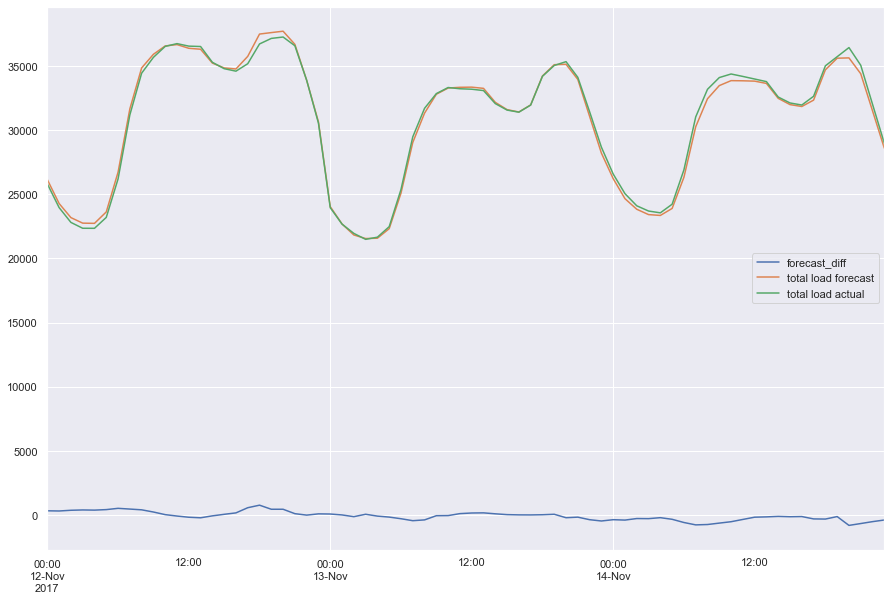

In [96]:
energy.loc['2017-11-12':'2017-11-14', ['forecast_diff', 'total load forecast', 'total load actual']].plot(figsize=(15,10));

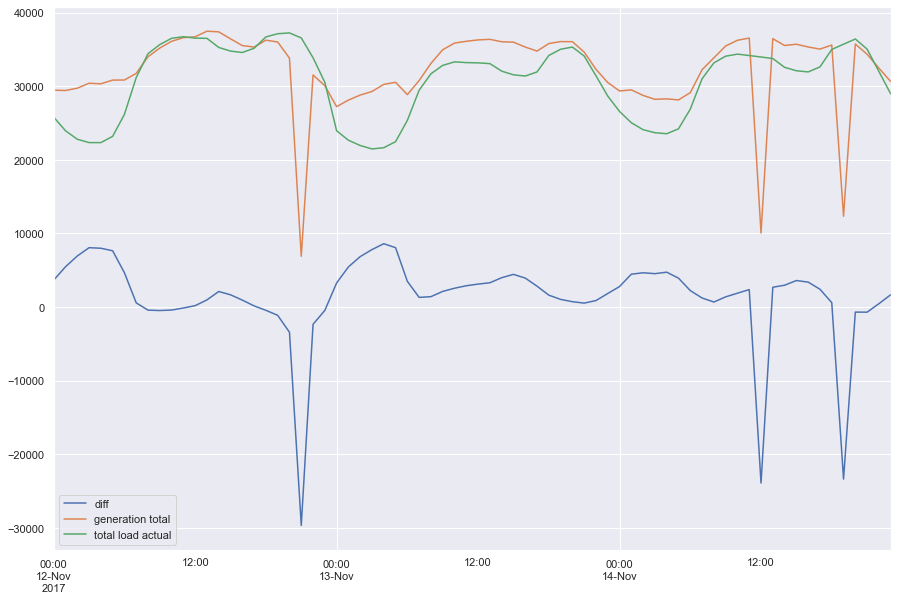

In [95]:
energy.loc['2017-11-12':'2017-11-14', ['diff', 'generation total', 'total load actual']].plot(figsize=(15,10));

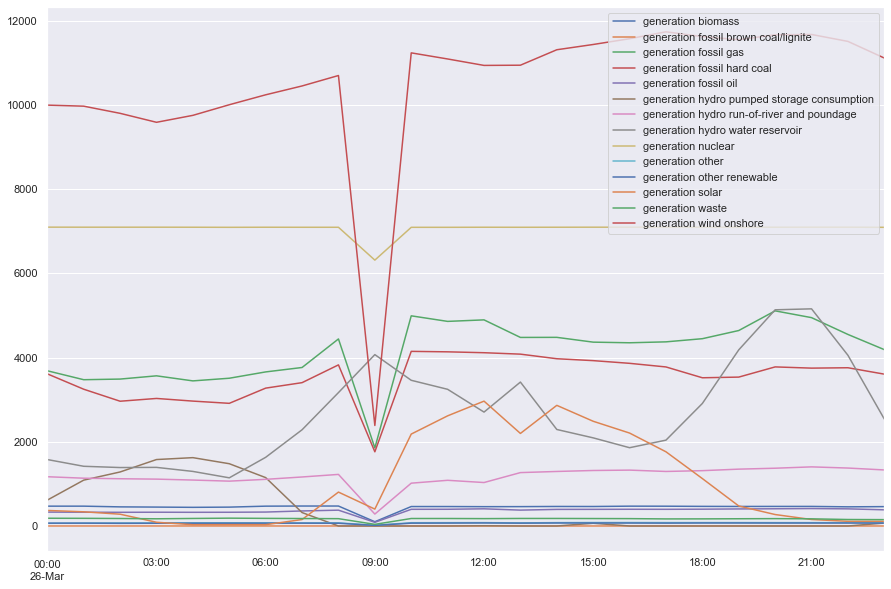

In [49]:
energy.loc['2015-03-26'].iloc[:,:14].plot(figsize=(15,10));

In [46]:
energy.loc['2015-03-26'].iloc[:,:20]

generation biomass  generation fossil brown coal/lignite  \
2015-03-26 00:00:00               471.0                                   0.0   
2015-03-26 01:00:00               471.0                                   0.0   
2015-03-26 02:00:00               454.0                                   0.0   
2015-03-26 03:00:00               449.0                                   0.0   
2015-03-26 04:00:00               443.0                                   0.0   
2015-03-26 05:00:00               448.0                                   0.0   
2015-03-26 06:00:00               471.0                                   0.0   
2015-03-26 07:00:00               474.0                                   0.0   
2015-03-26 08:00:00               474.0                                   0.0   
2015-03-26 09:00:00               101.0                                   0.0   
2015-03-26 10:00:00               462.0                                   0.0   
2015-03-26 11:00:00               462.0                                   0.0   
2015-03-26 12:00:00               459.0                                   0.0   
2015-03-26 13:00:00               460.0                                   0.0   
2015-03-26 14:00:00               464.0                                   0.0   
2015-03-26 15:00:00               463.0                                   0.0   
2015-03-26 16:00:00               471.0                                   0.0   
2015-03-26 17:00:00               470.0                                   0.0   
2015-03-26 18:00:00               466.0                                   0.0   
2015-03-26 19:00:00               464.0                                   0.0   
2015-03-26 20:00:00               465.0                                   0.0   
2015-03-26 21:00:00               465.0                                   0.0   
2015-03-26 22:00:00               455.0                                   0.0   
2015-03-26 23:00:00               460.0                                   0.0   

                     generation fossil gas  generation fossil hard coal  \
2015-03-26 00:00:00                 3686.0                       3613.0   
2015-03-26 01:00:00                 3474.0                       3248.0   
2015-03-26 02:00:00                 3489.0                       2963.0   
2015-03-26 03:00:00                 3566.0                       3029.0   
2015-03-26 04:00:00                 3446.0                       2966.0   
2015-03-26 05:00:00                 3509.0                       2913.0   
2015-03-26 06:00:00                 3659.0                       3274.0   
2015-03-26 07:00:00                 3764.0                       3404.0   
2015-03-26 08:00:00                 4442.0                       3826.0   
2015-03-26 09:00:00                 1854.0                       1762.0   
2015-03-26 10:00:00                 4991.0                       4147.0   
2015-03-26 11:00:00                 4859.0                       4136.0   
2015-03-26 12:00:00                 4895.0                       4115.0   
2015-03-26 13:00:00                 4478.0                       4081.0   
2015-03-26 14:00:00                 4480.0                       3972.0   
2015-03-26 15:00:00                 4366.0                       3927.0   
2015-03-26 16:00:00                 4351.0                       3863.0   
2015-03-26 17:00:00                 4373.0                       3777.0   
2015-03-26 18:00:00                 4448.0                       3520.0   
2015-03-26 19:00:00                 4642.0                       3536.0   
2015-03-26 20:00:00                 5109.0                       3778.0   
2015-03-26 21:00:00                 4948.0                       3749.0   
2015-03-26 22:00:00                 4549.0                       3758.0   
2015-03-26 23:00:00                 4188.0                       3606.0   

                     generation fossil oil  \
2015-03-26 00:00:00                  330.0   
2015-03-26 01:00:00        

## Daily Average Price Curve
___

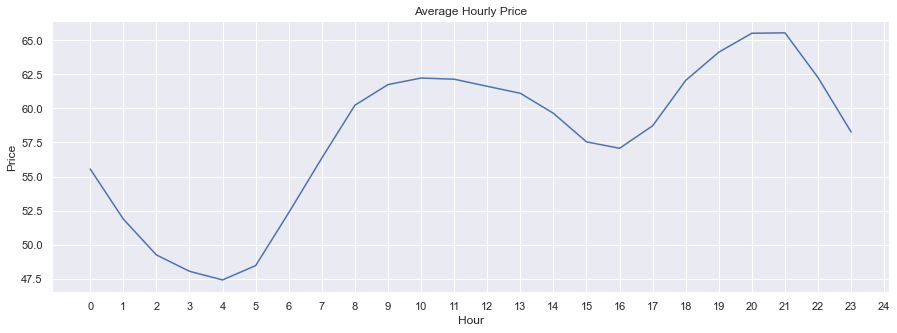

In [34]:
energy.groupby(by=energy.index.hour).mean()['price actual'].plot(figsize=(15,5), xticks=range(25));
plt.title('Average Hourly Price');
plt.xlabel('Hour');
plt.ylabel('Price');